<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#PDC-2020-Performance-Analysis" data-toc-modified-id="PDC-2020-Performance-Analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>PDC 2020 Performance Analysis</a></span><ul class="toc-item"><li><span><a href="#Compute" data-toc-modified-id="Compute-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Compute</a></span></li><li><span><a href="#Compare-with-existing-approaches" data-toc-modified-id="Compare-with-existing-approaches-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Compare with existing approaches</a></span></li></ul></li><li><span><a href="#PDC-2021-Performance-Analysis" data-toc-modified-id="PDC-2021-Performance-Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>PDC 2021 Performance Analysis</a></span><ul class="toc-item"><li><span><a href="#Compute" data-toc-modified-id="Compute-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Compute</a></span></li><li><span><a href="#Compare-with-existing-approaches" data-toc-modified-id="Compare-with-existing-approaches-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Compare with existing approaches</a></span></li></ul></li><li><span><a href="#BINET-Logs-Performance-Analysis" data-toc-modified-id="BINET-Logs-Performance-Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>BINET Logs Performance Analysis</a></span><ul class="toc-item"><li><span><a href="#Compute" data-toc-modified-id="Compute-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Compute</a></span></li><li><span><a href="#Compare-with-existing-approaches" data-toc-modified-id="Compare-with-existing-approaches-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Compare with existing approaches</a></span></li></ul></li><li><span><a href="#NSP-Accracy-vs-F1-Score" data-toc-modified-id="NSP-Accracy-vs-F1-Score-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>NSP Accracy vs F1 Score</a></span></li></ul></div>

In [ ]:
#default_exp performance

# Overall Performance

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#export
from dapnn.imports import *
from dapnn.data_processing import *

from dapnn.anomaly import *

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")

In [ ]:
notebook2script('05_performance.ipynb')

In [ ]:
#export
import warnings
warnings.filterwarnings(action='once')

## PDC 2020 Performance Analysis
>  Includes the performance analysis for the PDC 2020 event logs.

### Compute

In [ ]:
def load_pred_model(learner_path,train_log_path,log_name,cols=['activity']):
    p = f'{learner_path}/{log_name}_vocab.p'
    with open(p, 'rb') as fp:
        categorify = pickle.load(fp)
    log = import_log(train_log_path)
    o = process_test(log,categorify,cols)
    dls=o.get_dls()
    loss=partial(multi_loss_sum,o)
    emb_szs = get_emb_sz(o)
    m=MultivariateModel(emb_szs)
    learn=Learner(dls, m, path=learner_path, model_dir='.', loss_func=loss, metrics=get_metrics(o))
    learn.load(log_name,with_opt=False)
    m=learn.model.cuda()
    return m, categorify

def inference(test_log_path,m,categorify,log_name,cols=['activity'],fixed_threshold=None,override_threshold_func=None,anomaly_col='normal'):
    if type(test_log_path)==str:
        log = import_log(test_log_path)
    else:
        log = test_log_path   
    o = process_test(log,categorify,cols)
    nsp,idx=predict_next_step(o,m)
    score_df=multivariate_anomaly_score(nsp,o,idx,cols)
    if override_threshold_func is not None:
        y_true,y_pred=multivariate_anomalies(score_df,cols,idx,o,get_thresholds=override_threshold_func,anomaly_col=anomaly_col)
    else:
        y_true,y_pred=multivariate_anomalies(score_df,cols,idx,o,fixed_threshold=fixed_threshold,anomaly_col=anomaly_col)
    f1_score(y_true, y_pred)
    nsp_acc= float(nsp_accuracy(o,idx,nsp[0]))
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true,y_pred)
    recall = recall_score(y_true,y_pred)
    return [log_name, nsp_acc, f1, acc, precision, recall]

In [ ]:
pdc_year='2020'
learner_path=f'models/pdc{pdc_year}'
columns = ['log_name', 'NSP', 'F1 Score', 'Accuracy', 'Precision', 'Recall']

res=[]
for fn in progress_bar(glob.glob(f'data/csv/PDC{pdc_year}_training/*')):
    log_name = fn.split('.')[0].split('_')[-1]
    training_log_path = f'data/csv/PDC{pdc_year}_training/pdc_{pdc_year}_{log_name}.csv.gz'
    test_log_path = f'data/csv/PDC{pdc_year}_ground_truth/pdc_{pdc_year}_{log_name}.csv.gz'
    
    m, categorify= load_pred_model(learner_path,training_log_path,log_name)
    res.append(inference(test_log_path,m,categorify,log_name,fixed_threshold=0.99))
    
res_df=pd.DataFrame(res, columns = columns)

In [ ]:
res_df

,log_name,NSP,F1 Score,Accuracy,Precision,Recall
0,1001001,0.529353,0.857143,0.877,0.994609,0.753061
1,0111100,0.564505,0.904459,0.910,0.833659,0.988399
2,0000011,0.582535,0.885496,0.895,0.983051,0.805556
3,1000010,0.591469,0.933192,0.937,0.993228,0.880000
4,0201010,0.485777,0.795096,0.766,0.696319,0.926531
...,...,...,...,...,...,...
187,1200101,0.572423,0.792673,0.751,0.679030,0.952000
188,0111001,0.630535,0.909276,0.911,0.872798,0.948936
189,0110111,0.637627,0.873563,0.879,0.803846,0.956522
190,1210101,0.658973,0.887850,0.880,0.813356,0.977366


In [ ]:
means=res_df[list(res_df)[1:]].mean()
mean_f1_score=means[1]
means

NSP          0.586446
F1 Score     0.874235
Accuracy     0.872010
Precision    0.846093
Recall       0.918801
dtype: float64

In [ ]:
res_df

,log_name,NSP,F1 Score,Accuracy,Precision,Recall
0,1001001,0.529353,0.857143,0.877,0.994609,0.753061
1,0111100,0.564505,0.904459,0.910,0.833659,0.988399
2,0000011,0.582535,0.885496,0.895,0.983051,0.805556
3,1000010,0.591469,0.933192,0.937,0.993228,0.880000
4,0201010,0.485777,0.795096,0.766,0.696319,0.926531
...,...,...,...,...,...,...
187,1200101,0.572423,0.792673,0.751,0.679030,0.952000
188,0111001,0.630535,0.909276,0.911,0.872798,0.948936
189,0110111,0.637627,0.873563,0.879,0.803846,0.956522
190,1210101,0.658973,0.887850,0.880,0.813356,0.977366


In [ ]:
res_df.to_csv('results/pdc2020_0.99_25.csv',index=False)

### Compare with existing approaches

This image is from the PDC 2020 website:

![Image of Yaktocat](https://icpmconference.org/2020/wp-content/uploads/sites/4/2020/03/F-score-PDC-2020.png)


We copy over the results from the existing approaches from the graphic and enter the score of our DAPNN approach:

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
plt.style.use('ggplot')


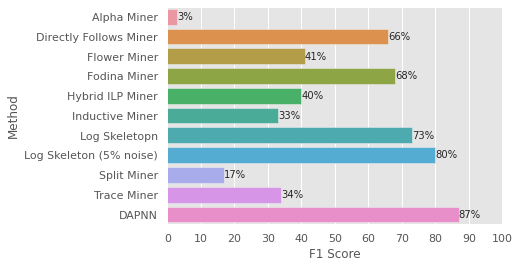

In [ ]:

cols= ['Method','F1 Score']

data =[
    ['Alpha Miner',0.03],
    ['Directly Follows Miner',0.66],
    ['Flower Miner',0.41],
        ['Fodina Miner',0.68],
    ['Hybrid ILP Miner',0.4],
    ['Inductive Miner',0.33],
    ['Log Skeletopn',0.73],
    ['Log Skeleton (5% noise)',0.8],
    ['Split Miner',0.17],
    ['Trace Miner',0.34],
    ['DAPNN',round(mean_f1_score,2)],

    
]
df=pd.DataFrame(data,columns=cols)
df['F1 Score']*=100

# add the plot



ax=sns.barplot(x='F1 Score',y='Method',data=df)
# add the annotation
ax.set_xlim(0,100)
ax.set_xticks(range(0,110,10))

ax.bar_label(ax.containers[-1], fmt='%.0f%%', label_type='edge');

## PDC 2021 Performance Analysis
>  Includes the performance analysis for the PDC 2021 event logs.

### Compute

In [ ]:
pdc_year='2021'
learner_path=f'models/pdc{pdc_year}'
columns = ['log_name', 'NSP', 'F1 Score', 'Accuracy', 'Precision', 'Recall']

res=[]
for fn in progress_bar(glob.glob(f'data/csv/PDC{pdc_year}_training/*')):
    log_name = fn.split('.')[0].split('_')[-1]
    training_log_path = f'data/csv/PDC{pdc_year}_training/pdc{pdc_year}_{log_name}.csv.gz'
    test_log_path = f'data/csv/PDC{pdc_year}_ground_truth/pdc{pdc_year}_{log_name[:-1]}.csv.gz'
    
    m, categorify= load_pred_model(learner_path,training_log_path,log_name)
    res.append(inference(test_log_path,m,categorify,log_name,fixed_threshold=0.98))
    
res_df=pd.DataFrame(res, columns = columns)

In [ ]:
res_df

,log_name,NSP,F1 Score,Accuracy,Precision,Recall
0,0010011,0.544108,0.909091,0.900,0.833333,1.000
1,0200003,0.579696,0.995984,0.996,1.000000,0.992
2,1001114,0.484127,0.987854,0.988,1.000000,0.976
3,1110100,0.564154,0.941634,0.940,0.916667,0.968
4,0100113,0.591829,1.000000,1.000,1.000000,1.000
...,...,...,...,...,...,...
475,1001014,0.497980,0.995984,0.996,1.000000,0.992
476,1100110,0.603706,0.962963,0.964,0.991525,0.936
477,1000004,0.537168,1.000000,1.000,1.000000,1.000
478,0010101,0.507105,0.992063,0.992,0.984252,1.000


In [ ]:
means=res_df[list(res_df)[1:]].mean()
mean_f1_score=means[1]
means

NSP          0.550654
F1 Score     0.961382
Accuracy     0.960150
Precision    0.950227
Recall       0.975400
dtype: float64

In [ ]:
res_df.to_csv(f'results/pdc{pdc_year}_0.99_25.csv',index=False)

### Compare with existing approaches

This image is from the PDC 2021 website:

![Image of Yaktocat](https://icpmconference.org/2021/wp-content/uploads/sites/5/2021/04/F-score-Overview.png)


We copy over the results from the existing approaches from the graphic and enter the score of our DAPNN approach:

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")

cols= ['Method','F1 Score']

data =[
    ['Alpha Miner',0.023],
    ['Directly Follows ',0.89],
    ['Directly Follows Model',0.719],
        ['DisCoveR CW',0.958],
    ['DisCoveR Light CW',0.953],
    ['Flower Miner',0],
    ['Fodina Miner',0.35],
    ['Hybrid ILP',0.464],
    ['Inductive IMfa',0.423],
    ['Kokos 2 T5',0.349],
    ['Log Skeleton N3',0.957],
        ['Split Miner',0.258],

    ['Trace Miner',0.154],

    ['DAPNN',round(mean_f1_score,2)],

    
]
df=pd.DataFrame(data,columns=cols)
df['F1 Score']*=100

# add the plot



ax=sns.barplot(x='F1 Score',y='Method',data=df)
# add the annotation
ax.set_xlim(0,108)
ax.set_xticks(range(0,110,10))

ax.bar_label(ax.containers[-1], fmt='%.1f%%', label_type='edge');

## BINET Logs Performance Analysis

### Compute

We have to override the load_pred and inference methods here.

Todo: Add storage of categorify for PDC data, so that we can use same methods.

In [ ]:
def load_pred_model(learner_path,train_log_path,log_name,cols=['activity']):
    p = f'{learner_path}/{log_name}_vocab.p'
    with open(p, 'rb') as fp:
        categorify = pickle.load(fp)
    log = import_log(train_log_path)
    o = process_test(log,categorify,cols)
    dls=o.get_dls()
    loss=partial(multi_loss_sum,o)
    emb_szs = get_emb_sz(o)
    m=MultivariateModel(emb_szs)
    learn=Learner(dls, m, path=learner_path, model_dir='.', loss_func=loss, metrics=get_metrics(o))
    learn.load(log_name,with_opt=False)
    m=learn.model.cuda()
    return m, categorify

def inference(test_log_path,m,categorify,log_name,cols=['activity'],fixed_threshold=None,override_threshold_func=None,anomaly_col='normal'):
    if type(test_log_path)==str:
        log = import_log(test_log_path)
    else:
        log = test_log_path   
    o = process_test(log,categorify,cols)
    nsp,idx=predict_next_step(o,m)
    score_df=multivariate_anomaly_score(nsp,o,idx,cols)
    if override_threshold_func is not None:
        y_true,y_pred=multivariate_anomalies(score_df,cols,idx,o,get_thresholds=override_threshold_func,anomaly_col=anomaly_col)
    else:
        y_true,y_pred=multivariate_anomalies(score_df,cols,idx,o,fixed_threshold=fixed_threshold,anomaly_col=anomaly_col)
    f1_score(y_true, y_pred)
    nsp_acc= float(nsp_accuracy(o,idx,nsp[0]))
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true,y_pred)
    recall = recall_score(y_true,y_pred)
    return [log_name, nsp_acc, f1, acc, precision, recall]

In [ ]:
learner_path=f'models/binet_logs'
columns = ['log_name', 'NSP', 'F1 Score', 'Accuracy', 'Precision', 'Recall']

res=[]
for fn in progress_bar(glob.glob(f'data/csv/binet_logs/*')):
    log_name = fn.split('/')[-1][:-7]
    m, categorify= load_pred_model(learner_path,fn,log_name,cols=get_attr(attr_dict,fn))    
    res.append(inference(fn,m,categorify,log_name,fixed_threshold=0.99,anomaly_col='anomaly'))

res_df=pd.DataFrame(res, columns = columns)

/home/lahann/dapnn/dapnn/data_processing.py:49: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(log_path)
/home/lahann/dapnn/dapnn/data_processing.py:49: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(log_path)
/home/lahann/dapnn/dapnn/data_processing.py:49: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(log_path)
/home/lahann/dapnn/dapnn/data_processing.py:49: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(log_path)
/home/lahann/dapnn/dapnn/data_processing.py:49: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(log_path)
/home/lahann/dapnn/dapnn/data_processing.py:49: DtypeWarning: Columns (17) have mixed types. Specify dtype option on imp

In [ ]:
res_df.sort_values('log_name')

,log_name,NSP,F1 Score,Accuracy,Precision,Recall
12,bpic12-0.3-1,0.847987,0.721965,0.852984,0.834614,0.636109
10,bpic13-0.3-1,0.666865,0.417204,0.817754,0.960396,0.266484
28,bpic13-0.3-2,0.687630,0.519599,0.790707,0.826886,0.378821
3,bpic13-0.3-3,0.523546,0.303665,0.837607,1.000000,0.179012
22,bpic15-0.3-1,0.580140,0.529651,0.517098,0.387634,0.835897
20,bpic15-0.3-2,0.498410,0.473318,0.454327,0.323810,0.879310
30,bpic15-0.3-3,0.617307,0.531609,0.537260,0.387841,0.844749
0,bpic15-0.3-4,0.641939,0.516878,0.565052,0.382215,0.798046
31,bpic15-0.3-5,0.587537,0.511893,0.556228,0.371034,0.825153
6,bpic17-0.3-1,0.863563,0.718565,0.837189,0.741676,0.696850


In [ ]:
means=res_df[list(res_df)[1:]].mean()
mean_f1_score=means[1]
means

NSP          0.795103
F1 Score     0.710648
Accuracy     0.837388
Precision    0.903719
Recall       0.635644
dtype: float64

In [ ]:
res_df.to_csv(f'results/binet_logs_0.99_25.csv',index=False)

Calculate score per Dataset Group, i.e. grouping small, medium, ..., Wide datasets

In [ ]:
ds=['Paper','P2P','Small','Medium','Large','Huge','Gigantic','Wide','BPIC12','BPIC13','BPIC15','BPIC17']

dappn_f1scores = pd.DataFrame([[res_df[res_df['log_name'].str.contains(i.lower())]['F1 Score'].mean() for i in ds]],columns=ds,index=['DAPNN'])
dappn_f1scores 

### Compare with existing approaches

Load results from the BINET Classification paper from their github

In [ ]:
binet_paper =pd.read_csv('data/binet_classification_paper_results.csv',index_col='ad')
binet_paper

,BPIC12,BPIC13,BPIC15,BPIC17,Gigantic,Huge,Large,Medium,P2P,Paper,Small,Wide,real
ad,,,,,,,,,,,,,
BINetv1,0.620944,0.398025,0.345685,0.468883,0.711138,0.713072,0.713074,0.734423,0.767615,0.739184,0.772470,0.760635,0.600066
BINetv2,0.606927,0.396996,0.375067,0.430140,0.679595,0.703973,0.710234,0.719155,0.767929,0.756928,0.774670,0.733343,0.551377
BINetv3,0.664307,0.445716,0.362319,0.488593,0.662312,0.692879,0.692470,0.708821,0.769265,0.790624,0.762479,0.738014,0.634719
DAE,0.595470,0.206788,0.000000,0.295293,0.627368,0.703465,0.712646,0.708075,0.707719,0.463016,0.715753,0.697157,0.518530
Likelihood,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Likelihood+,0.624890,0.445332,0.329043,0.398566,0.665235,0.676236,0.622254,0.654382,0.610554,0.656008,0.688263,0.637159,0.629704
Naive,0.550801,0.208840,0.172457,0.313211,0.339600,0.403836,0.410308,0.387077,0.478745,0.500000,0.490269,0.437958,0.385002
Naive+,0.550801,0.208840,0.173097,0.275905,0.383237,0.453975,0.490268,0.439200,0.479733,0.500000,0.488315,0.469081,0.331977
OC-SVM,0.545289,0.243008,0.255417,0.351496,0.290641,0.227865,0.236562,0.288863,0.270747,0.485720,0.247770,0.306014,0.296537


In [ ]:
res_f1 = pd.concat([binet_paper,dappn_f1scores])
res_f1= res_f1[res_f1.columns[:-1]]
res_f1

,BPIC12,BPIC13,BPIC15,BPIC17,Gigantic,Huge,Large,Medium,P2P,Paper,Small,Wide
BINetv1,0.620944,0.398025,0.345685,0.468883,0.711138,0.713072,0.713074,0.734423,0.767615,0.739184,0.772470,0.760635
BINetv2,0.606927,0.396996,0.375067,0.430140,0.679595,0.703973,0.710234,0.719155,0.767929,0.756928,0.774670,0.733343
BINetv3,0.664307,0.445716,0.362319,0.488593,0.662312,0.692879,0.692470,0.708821,0.769265,0.790624,0.762479,0.738014
DAE,0.595470,0.206788,0.000000,0.295293,0.627368,0.703465,0.712646,0.708075,0.707719,0.463016,0.715753,0.697157
Likelihood,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Likelihood+,0.624890,0.445332,0.329043,0.398566,0.665235,0.676236,0.622254,0.654382,0.610554,0.656008,0.688263,0.637159
Naive,0.550801,0.208840,0.172457,0.313211,0.339600,0.403836,0.410308,0.387077,0.478745,0.500000,0.490269,0.437958
Naive+,0.550801,0.208840,0.173097,0.275905,0.383237,0.453975,0.490268,0.439200,0.479733,0.500000,0.488315,0.469081
OC-SVM,0.545289,0.243008,0.255417,0.351496,0.290641,0.227865,0.236562,0.288863,0.270747,0.485720,0.247770,0.306014
Sampling,0.545733,0.207405,0.172464,0.323376,0.445685,0.490602,0.494373,0.465417,0.490045,0.495158,0.491562,0.485906


In [ ]:
res_f1['Mean']=res_f1.mean(axis=1)
res_f1=res_f1.sort_values('Mean')
res_f1

,BPIC12,BPIC13,BPIC15,BPIC17,Gigantic,Huge,Large,Medium,P2P,Paper,Small,Wide,Mean
Likelihood,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OC-SVM,0.545289,0.243008,0.255417,0.351496,0.290641,0.227865,0.236562,0.288863,0.270747,0.485720,0.247770,0.306014,0.312449
Naive,0.550801,0.208840,0.172457,0.313211,0.339600,0.403836,0.410308,0.387077,0.478745,0.500000,0.490269,0.437958,0.391092
Naive+,0.550801,0.208840,0.173097,0.275905,0.383237,0.453975,0.490268,0.439200,0.479733,0.500000,0.488315,0.469081,0.409371
Sampling,0.545733,0.207405,0.172464,0.323376,0.445685,0.490602,0.494373,0.465417,0.490045,0.495158,0.491562,0.485906,0.425644
t-STIDE+,0.677794,0.318932,0.286813,0.323687,0.405928,0.445531,0.452811,0.429467,0.508627,0.403507,0.531487,0.470728,0.437943
DAE,0.595470,0.206788,0.000000,0.295293,0.627368,0.703465,0.712646,0.708075,0.707719,0.463016,0.715753,0.697157,0.536063
Likelihood+,0.624890,0.445332,0.329043,0.398566,0.665235,0.676236,0.622254,0.654382,0.610554,0.656008,0.688263,0.637159,0.583993
BINetv2,0.606927,0.396996,0.375067,0.430140,0.679595,0.703973,0.710234,0.719155,0.767929,0.756928,0.774670,0.733343,0.637913
BINetv1,0.620944,0.398025,0.345685,0.468883,0.711138,0.713072,0.713074,0.734423,0.767615,0.739184,0.772470,0.760635,0.645429


In [ ]:
def highlight_max(s):
    is_max = s == s.max()
    return [f"\\textbf{{{x}}}" if is_max[i] else str(x) for i,x in enumerate(s)]

res_f1 = res_f1.round(3)
latex_exp = res_f1.apply(highlight_max)
print(latex_exp.style.to_latex())

\begin{tabular}{llllllllllllll}
 & BPIC12 & BPIC13 & BPIC15 & BPIC17 & Gigantic & Huge & Large & Medium & P2P & Paper & Small & Wide & Mean \\
Likelihood & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
OC-SVM & 0.545 & 0.243 & 0.255 & 0.351 & 0.291 & 0.228 & 0.237 & 0.289 & 0.271 & 0.486 & 0.248 & 0.306 & 0.312 \\
Naive & 0.551 & 0.209 & 0.172 & 0.313 & 0.34 & 0.404 & 0.41 & 0.387 & 0.479 & 0.5 & 0.49 & 0.438 & 0.391 \\
Naive+ & 0.551 & 0.209 & 0.173 & 0.276 & 0.383 & 0.454 & 0.49 & 0.439 & 0.48 & 0.5 & 0.488 & 0.469 & 0.409 \\
Sampling & 0.546 & 0.207 & 0.172 & 0.323 & 0.446 & 0.491 & 0.494 & 0.465 & 0.49 & 0.495 & 0.492 & 0.486 & 0.426 \\
t-STIDE+ & 0.678 & 0.319 & 0.287 & 0.324 & 0.406 & 0.446 & 0.453 & 0.429 & 0.509 & 0.404 & 0.531 & 0.471 & 0.438 \\
DAE & 0.595 & 0.207 & 0.0 & 0.295 & 0.627 & 0.703 & 0.713 & 0.708 & 0.708 & 0.463 & 0.716 & 0.697 & 0.536 \\
Likelihood+ & 0.625 & 0.445 & 0.329 & 0.399 & 0.665 & 0.676 & 0.622 & 0.654 & 0.611 & 0.656 &

Mean F1 of BPIC and synthetic Logs

In [ ]:
res_f1.iloc[-1][:4].mean(),res_f1.iloc[-1][4:].mean()

(0.5835, 0.8627777777777778)

## NSP Accracy vs F1 Score 

Compares the NSP accracy and the F1 score 

In [ ]:
df1 =pd.read_csv('results/pdc2020_0.98_25.csv')
df1.head()

,log_name,NSP,F1 Score,Accuracy,Precision,Recall
0,1001001,0.524736,0.888889,0.899,0.964200,0.824490
1,111100,0.565601,0.919786,0.925,0.853175,0.997680
2,11,0.580948,0.916155,0.918,0.945148,0.888889
3,1000010,0.586482,0.942740,0.944,0.964435,0.922000
4,201010,0.490515,0.802013,0.764,0.680912,0.975510


In [ ]:
df2 =pd.read_csv('results/pdc2021_0.98_25.csv')
df2.head()

,log_name,NSP,F1 Score,Accuracy,Precision,Recall
0,10011,0.507990,0.915751,0.908,0.844595,1.000
1,200003,0.582775,1.000000,1.000,1.000000,1.000
2,1001114,0.491924,0.975410,0.976,1.000000,0.952
3,1110100,0.547687,0.909774,0.904,0.858156,0.968
4,100113,0.579173,0.979592,0.980,1.000000,0.960


In [ ]:
df3 =pd.read_csv('results/binet_logs_0.98_25.csv')
df3.head()

,log_name,NSP,F1 Score,Accuracy,Precision,Recall
0,bpic15-0.3-4,0.641939,0.492674,0.473884,0.342675,0.876221
1,large-0.3-4,0.881100,0.921909,0.956800,1.000000,0.855131
2,small-0.3-4,0.889390,0.885162,0.937000,1.000000,0.793983
3,bpic13-0.3-3,0.523546,0.370000,0.846154,0.973684,0.228395
4,medium-0.3-3,0.773404,0.777202,0.888200,1.000000,0.635593


In [ ]:
df1['Data']='PDC 2020'
df2['Data']='PDC 2021'
df3['Data']='BINET Logs'

In [ ]:
res_df = pd.concat([df1,df2,df3])

In [ ]:
res_df=res_df.groupby('Data',sort=False).apply(lambda x: x.sort_values('F1 Score'))

In [ ]:
plot_data = res_df.melt(id_vars=['log_name','Data','Accuracy','Precision','Recall'],value_vars=['NSP','F1 Score'],value_name='Score',var_name='Metric')

In [ ]:
plot_data.head()

,log_name,Data,Accuracy,Precision,Recall,Metric,Score
0,200110,PDC 2020,0.677,0.561210,0.990291,NSP,0.537389
1,200111,PDC 2020,0.687,0.569425,0.985437,NSP,0.540546
2,1200110,PDC 2020,0.676,0.588542,0.982609,NSP,0.574400
3,200011,PDC 2020,0.689,0.609150,0.974895,NSP,0.552019
4,1200111,PDC 2020,0.700,0.608108,0.978261,NSP,0.581962


In [ ]:
plot_data['Log']=plot_data.groupby(['Data','Metric']).cumcount()


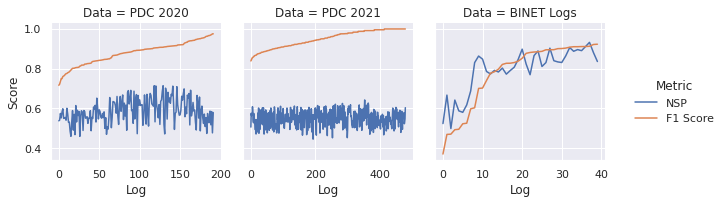

In [ ]:
g = sns.FacetGrid(plot_data, col="Data",hue='Metric',sharex=False,margin_titles=True)
g.map_dataframe(sns.lineplot, x="Log", y="Score")
g.add_legend()
